---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Weekly Tasks 2</span>

##### Tasks:
- Use K-Means clustering to group houses by price (Assignment 1 dataset)
- Visualise clustering results and select the best configurations
- Choose another clustering method and compare results
- Model the data to find the price based on the input features

##### Data Preparation Note:
For details on the data preparation process, please refer to the data folder at **Clustering\Weekly Tasks\data**. The original dataset provided by the lecturer was enhanced with additional data from Kaggle (https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) to increase the number of features available for clustering analysis. This enhancement was done with the aim of improving the clustering results, as more features typically lead to more meaningful and insightful clusters.

##### <span style="color: #1E90FF;">[Click here to jump to the main solution for clustering and model building](#clustering-and-model-building)</span>

---------------------------------------------------------------------------------------------------------------------------------

In [1]:
# Install required libraries
%pip install pandas numpy matplotlib seaborn scikit-learn wordcloud xgboost statsmodels 
%pip install shap lime 

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Import Required Libraries</span>
##### This code imports the required libraries for data manipulation, visualization, and machine learning tasks.

In [2]:
#Import required libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import sys

assert sys.version_info >= (3, 7)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


---------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Basic Exploratory Data Analysis (EDA)</span>
##### This section performs an in-depth EDA on the cleaned dataset:


##### <span style="color: #1E90FF;">Univariate Analysis:</span>
##### • Visualize log-transformed house prices and key numeric features

##### <span style="color: #1E90FF;">Bivariate Analysis:</span>
##### • Create correlation matrix heatmap and scatter plots

##### <span style="color: #1E90FF;">Categorical Variable Analysis:</span>
##### • Analyze high cardinality features like 'City' and 'State'

##### <span style="color: #1E90FF;">Data Quality Checks:</span>
##### • Implement column existence checks, handle missing values

##### <span style="color: #1E90FF;">Advanced Visualizations:</span>
##### • Use seaborn for enhanced graphics, create multi-plot figures

##### <span style="color: #1E90FF;">Performance Considerations:</span>
##### • Efficient data handling, appropriate plot sizes and layouts

##### Insights from this analysis are saved in: Weekly Tasks\Visualisation Outputs\Insights\Task 2 EDA Insights.md

Data loaded successfully. Shape: (30683, 25)
Starting EDA...
Data cleaned successfully.
Data standardized successfully.


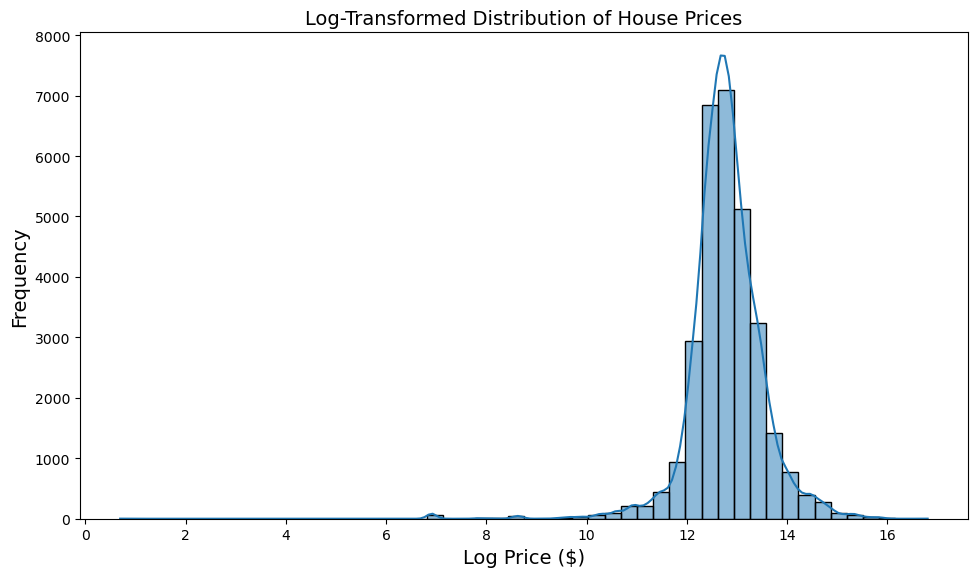

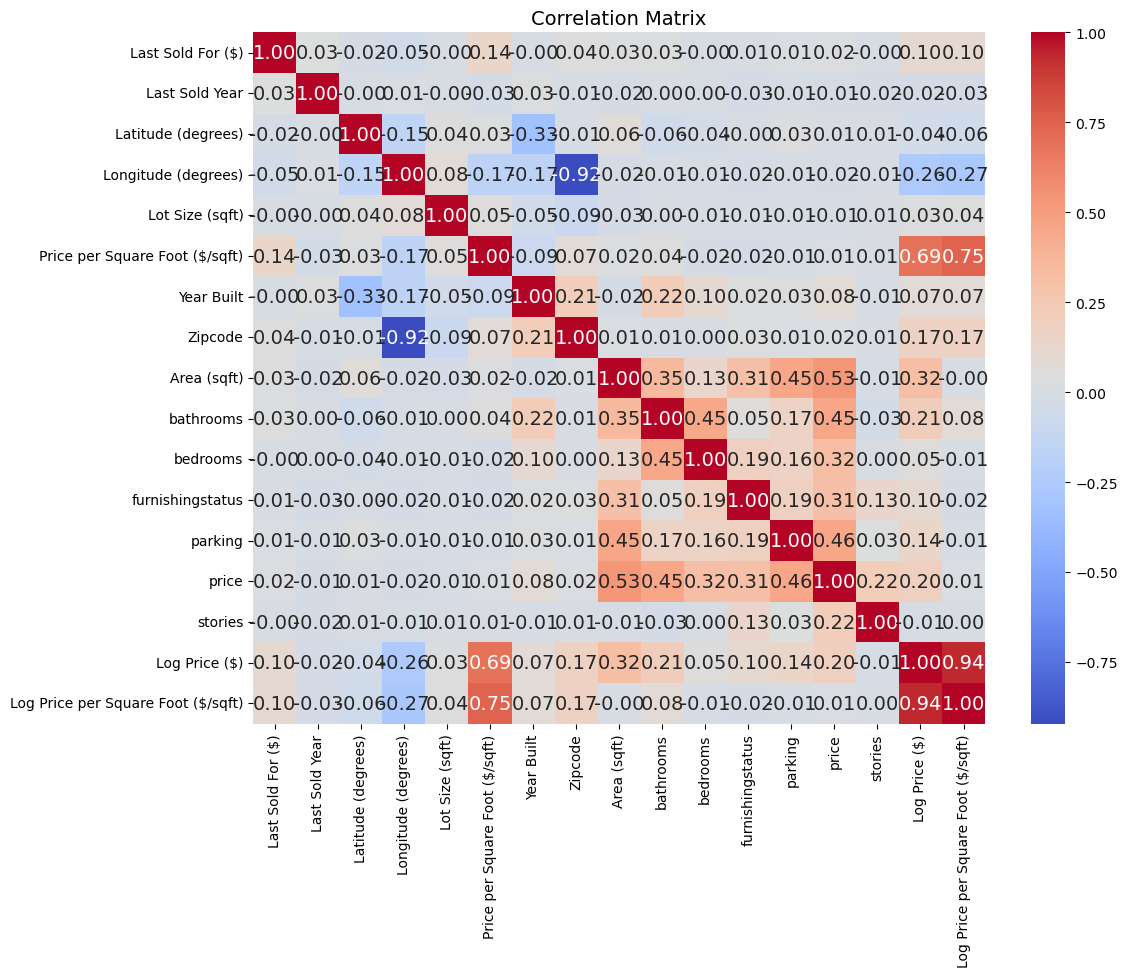

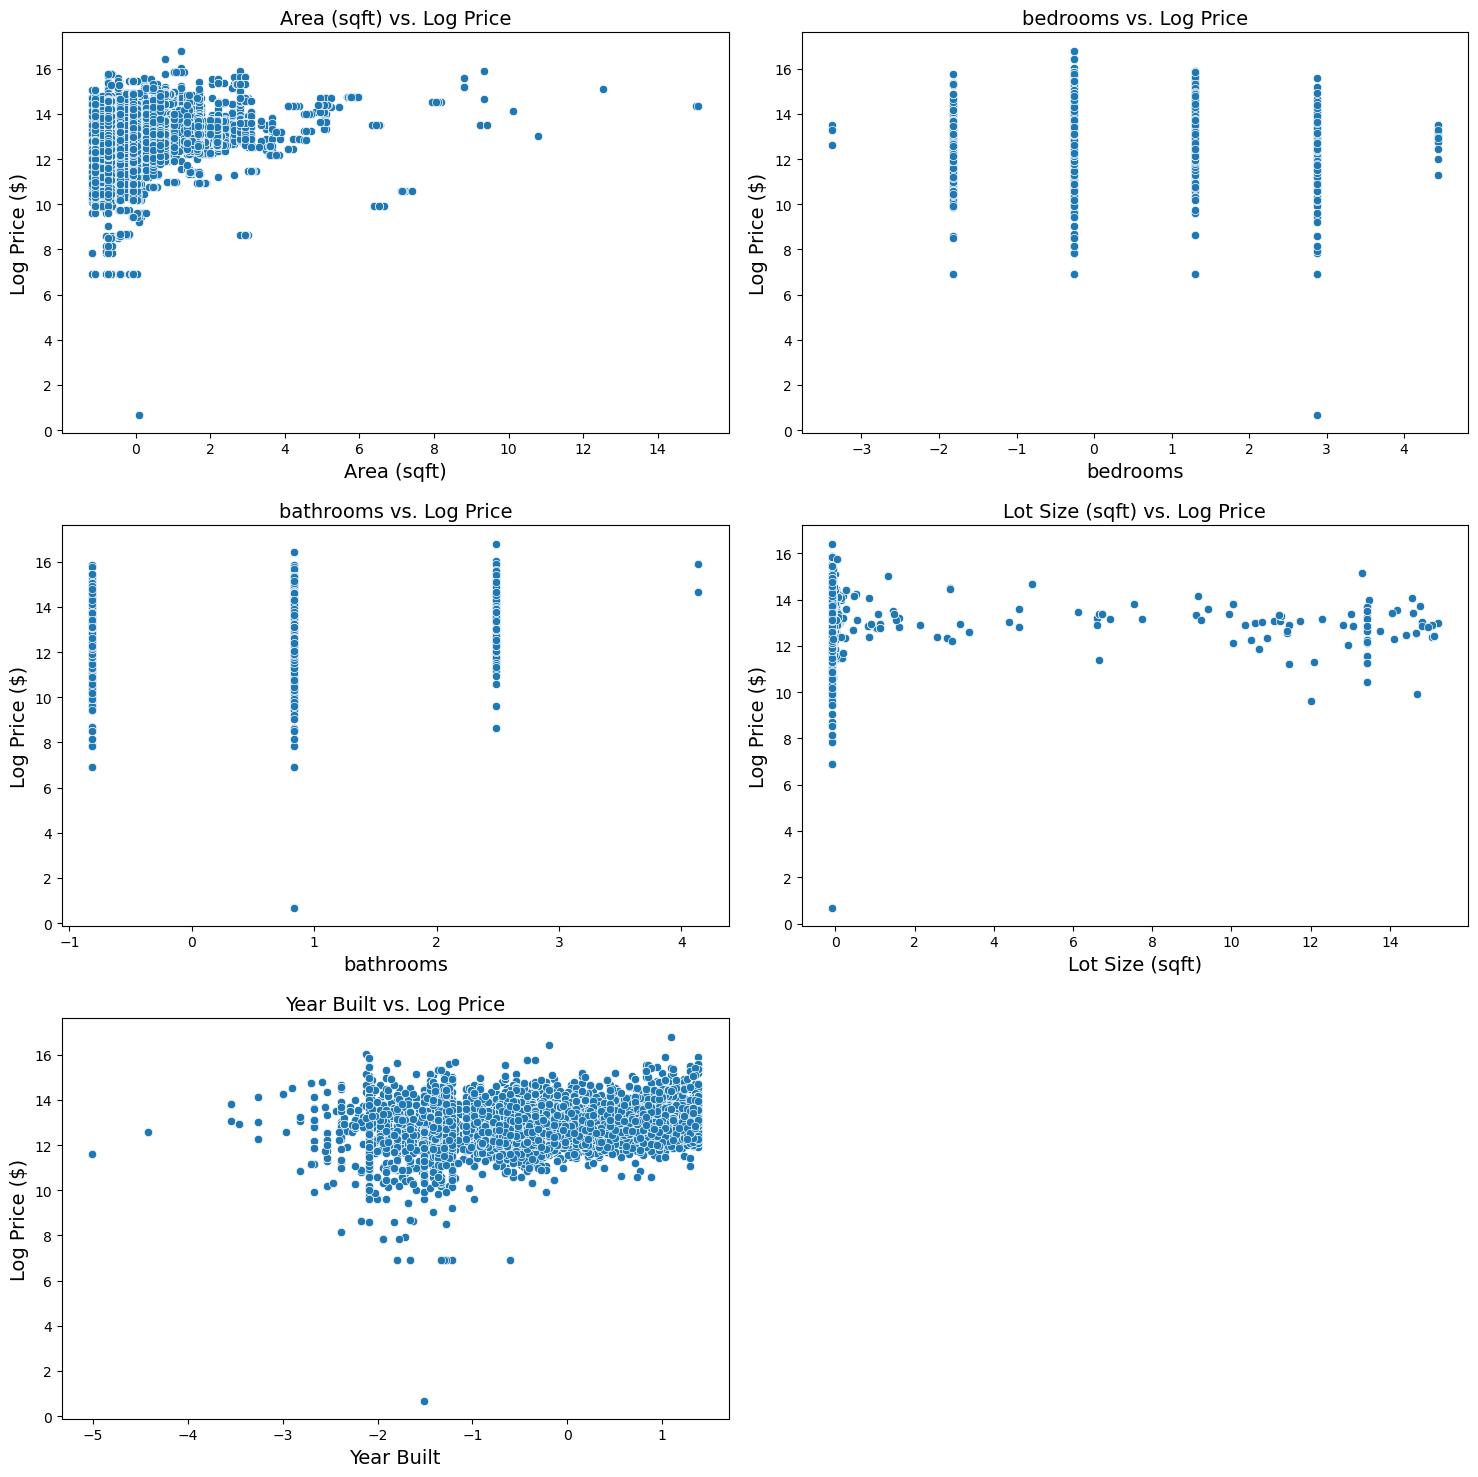

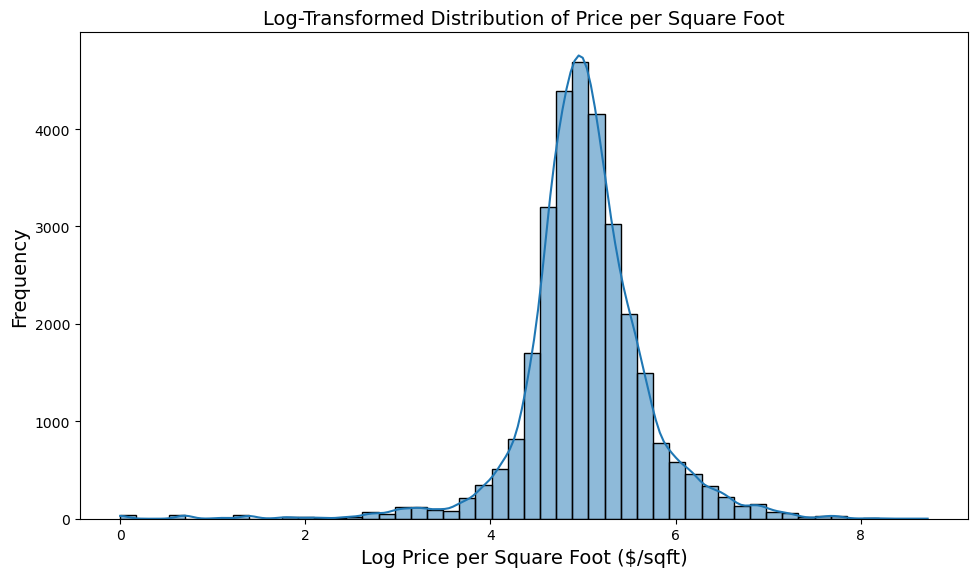

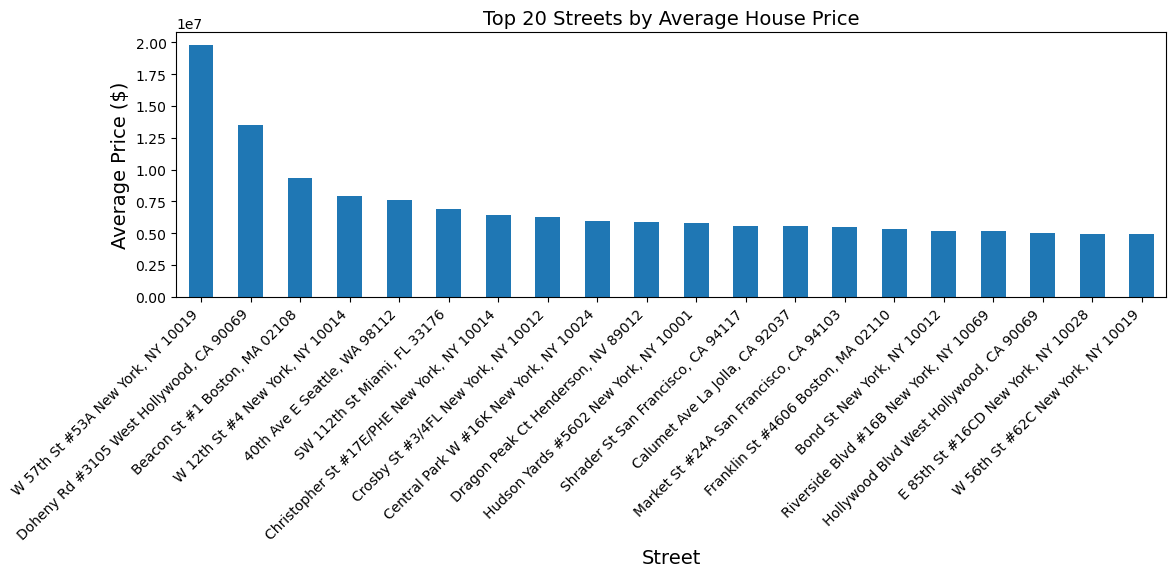

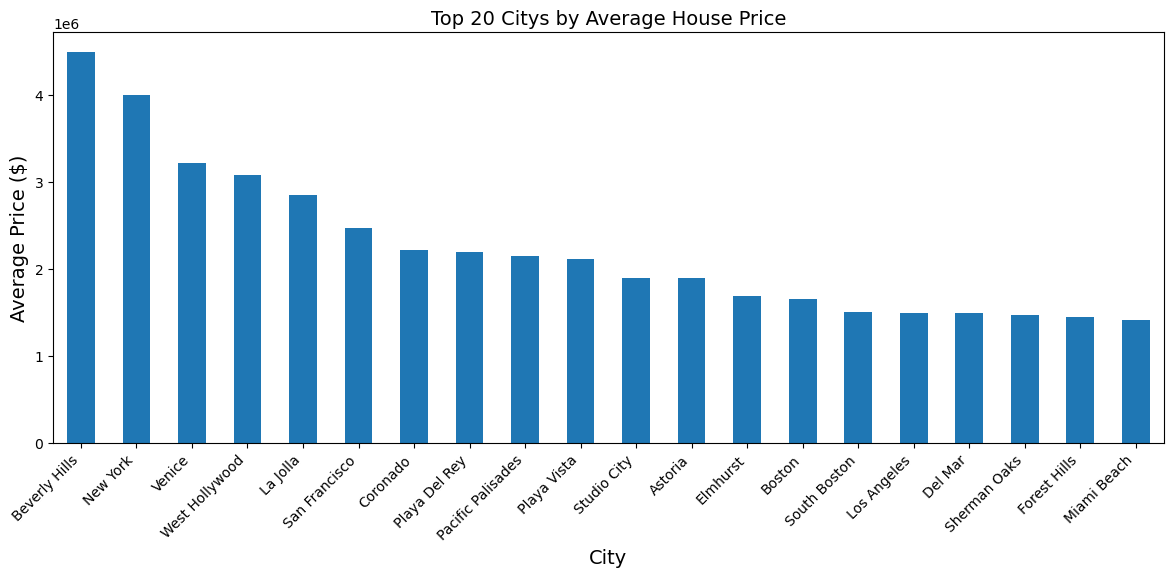

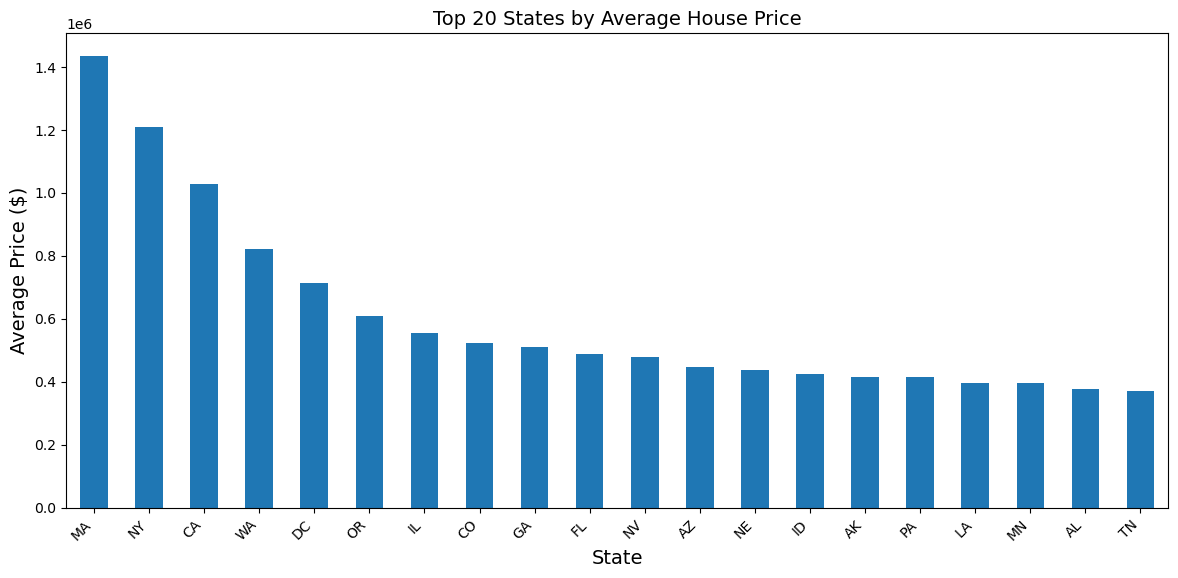

EDA completed successfully.


In [3]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Exploratory Data Analysis Class
class ExploratoryDataAnalysis:
    def __init__(self, df):
        """
        Initialize the EDA with a DataFrame.

        Parameters:
        df (pd.DataFrame): The DataFrame to perform EDA on.
        """
        self.df = df.copy()
        self.numeric_features = ['Area (sqft)', 'bedrooms', 'bathrooms', 'Lot Size (sqft)', 'Year Built']
        self.high_cardinality_cols = ['Price per Square Foot ($/sqft)', 'Address', 'City', 'State']
        self.output_folder = r"E:\Uni\2nd year\Intro to AI\Regression\assignment-1-ryantigi254\Regression\Weekly Tasks\main task\Visualisation Outputs\Basic EDA Plots"
        os.makedirs(self.output_folder, exist_ok=True)

    def check_column_exists(self, column_name):
        """
        Check if a column exists in the DataFrame.

        Parameters:
        column_name (str): The name of the column to check.

        Returns:
        bool: True if the column exists, False otherwise.
        """
        if column_name not in self.df.columns:
            print(f"Error: '{column_name}' column not found in the dataframe.")
            return False
        return True

    def clean_data(self):
        """
        Clean the DataFrame for analysis.

        - Convert 'Price ($)' to numeric, handling 'Contact For Estimate'.
        - Ensure all numeric features are converted to numeric data types.
        - Apply log transformations to 'Price ($)' and 'Price per Square Foot ($/sqft)'.
        """
        # Clean 'Price ($)' column
        self.clean_price_column()

        # Convert numeric features to appropriate data types
        self.convert_numeric_features()

        # Log transform 'Price ($)'
        if self.check_column_exists('Price ($)'):
            self.df['Log Price ($)'] = np.log1p(self.df['Price ($)'])

        # Log transform 'Price per Square Foot ($/sqft)'
        if self.check_column_exists('Price per Square Foot ($/sqft)'):
            self.df['Log Price per Square Foot ($/sqft)'] = np.log1p(self.df['Price per Square Foot ($/sqft)'])

    def clean_price_column(self):
        """Convert 'Price ($)' to numeric, handling special cases."""
        if self.check_column_exists('Price ($)'):
            self.df['Price ($)'] = self.df['Price ($)'].replace('Contact For Estimate', np.nan)
            self.df['Price ($)'] = pd.to_numeric(self.df['Price ($)'], errors='coerce')

    def convert_numeric_features(self):
        """Ensure all specified numeric features are converted to numeric data types."""
        for feature in self.numeric_features:
            if self.check_column_exists(feature):
                self.df[feature] = pd.to_numeric(self.df[feature], errors='coerce')

    def standardize_numeric_data(self):
        """Standardize numeric features for K-Means clustering."""
        scaler = StandardScaler()
        valid_features = [feature for feature in self.numeric_features if self.check_column_exists(feature)]
        self.df[valid_features] = scaler.fit_transform(self.df[valid_features])

    def plot_distribution(self, column_name, title, xlabel):
        """
        Plot the distribution of a given numeric column.

        Parameters:
        column_name (str): The name of the column to plot.
        title (str): The title of the plot.
        xlabel (str): The label for the x-axis.
        """
        if self.check_column_exists(column_name):
            plt.figure(figsize=(10, 6))
            sns.histplot(self.df[column_name].dropna(), bins=50, kde=True)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel('Frequency')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, f"{title.replace(' ', '_')}.png"))
            plt.show()
            plt.close()

    def plot_correlation_matrix(self):
        """
        Plot the correlation matrix for numeric features.
        """
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != 'Price ($)']
        if len(numeric_cols) > 1:
            plt.figure(figsize=(12, 10))
            corr_matrix = self.df[numeric_cols].corr()
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Correlation_Matrix.png"))
            plt.show()
            plt.close()
        else:
            print("Not enough numeric columns to plot a correlation matrix.")

    def plot_scatter_plots(self):
        """
        Generate scatter plots for each numeric feature against Log Price.
        """
        if self.check_column_exists('Log Price ($)'):
            valid_features = [feature for feature in self.numeric_features if self.check_column_exists(feature)]
            num_plots = len(valid_features)
            if num_plots == 0:
                print("No valid numeric features available for plotting.")
                return
            rows = (num_plots + 1) // 2
            fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
            axes = axes.flatten()
            for idx, feature in enumerate(valid_features):
                sns.scatterplot(
                    data=self.df,
                    x=feature,
                    y='Log Price ($)',
                    ax=axes[idx]
                )
                axes[idx].set_title(f'{feature} vs. Log Price')
                axes[idx].set_xlabel(feature)
                axes[idx].set_ylabel('Log Price ($)')
            # Remove any unused subplots
            for idx in range(num_plots, len(axes)):
                fig.delaxes(axes[idx])
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Scatter_Plots.png"))
            plt.show()
            plt.close()

    def plot_top_categories(self, category_col, value_col, top_n, title):
        plt.figure(figsize=(12, 6))
        avg_values = self.df.groupby(category_col)[value_col].mean().nlargest(top_n)
        avg_values.plot(kind='bar')
        plt.title(title)
        plt.xlabel(category_col)
        plt.ylabel(f'Average {value_col}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(os.path.join(self.output_folder, f"{title.replace(' ', '_')}.png"))
        plt.show()
        plt.close()

    def plot_top_streets(self):
        """
        Plot top 20 streets by average house price.
        """
        if self.check_column_exists('Address') and self.check_column_exists('Price ($)'):
            # Extract street names from addresses
            self.df['Street'] = self.df['Address'].apply(lambda x: ' '.join(str(x).split()[1:]))
            
            # Calculate average price for each street
            street_prices = self.df.groupby('Street')['Price ($)'].mean()
            
            # Get top 20 streets by average price
            top_streets = street_prices.nlargest(20)
            
            plt.figure(figsize=(12, 6))
            top_streets.plot(kind='bar')
            plt.title('Top 20 Streets by Average House Price')
            plt.xlabel('Street')
            plt.ylabel('Average Price ($)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(self.output_folder, "Top_20_Streets_by_Average_Price.png"))
            plt.show()
            plt.close()
        else:
            print("Required columns for street analysis are not available.")

    def handle_high_cardinality_features(self):
        """
        Visualize high cardinality features including 'Address'.
        """
        for col in self.high_cardinality_cols:
            if self.check_column_exists(col):
                if col in ['State', 'City']:
                    self.plot_top_categories(col, 'Price ($)', 20, f'Top 20 {col}s by Average House Price')
                elif col == 'Price per Square Foot ($/sqft)':
                    self.plot_distribution(
                        column_name='Log Price per Square Foot ($/sqft)',
                        title='Log-Transformed Distribution of Price per Square Foot',
                        xlabel='Log Price per Square Foot ($/sqft)'
                    )
                elif col == 'Address':
                    self.plot_top_streets()

    def perform_eda(self):
        """
        Execute the complete EDA process:
        - Clean data
        - Standardize data
        - Plot distributions
        - Plot correlation matrix
        - Plot scatter plots
        - Handle high cardinality features
        """
        print("Starting EDA...")
        self.clean_data()
        print("Data cleaned successfully.")

        # Standardize data for further analysis
        self.standardize_numeric_data()
        print("Data standardized successfully.")

        # Plot distributions
        self.plot_distribution('Log Price ($)', 'Log-Transformed Distribution of House Prices', 'Log Price ($)')

        # Plot correlation matrix
        self.plot_correlation_matrix()

        # Plot scatter plots
        self.plot_scatter_plots()

        # Handle high cardinality features
        self.handle_high_cardinality_features()
        print("EDA completed successfully.")

# Main execution
def main():
    file_path = r"E:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv"

    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
    else:
        try:
            df = pd.read_csv(file_path)
            if df.empty:
                print("Error: The DataFrame is empty. Unable to perform EDA.")
            else:
                print(f"Data loaded successfully. Shape: {df.shape}")
                eda = ExploratoryDataAnalysis(df)
                eda.perform_eda()
        except Exception as e:
            print(f"An error occurred during EDA: {str(e)}")

if __name__ == "__main__":
    main()

---------------------------------------------------------------------------------------------------------------------------------

##### <span style="color: #FF0000;">Miscellaneous- Personal use and reference</span>
